KLM flight delay prediction

In [31]:
import requests
import numpy 
import smtplib, ssl
import pandas as pd
import json
from datetime import datetime, timedelta, timezone
import datetime as dt
import requests
import time 
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt 
from scipy.stats import chi2_contingency 

In [1183]:
url = "https://api.airfranceklm.com/opendata/flightstatus"

headers = {
    "Accept-Language": "",
    "API-Key": "f3ybnyzt6aq85px4ggbj5yxq",
    "Accept": "application/hal+json"
}

date_start = dt.date(2025, 10, 7)
date_end = dt.date(2025, 10, 10) 



startRange = f"{date_start}T00:00:00.000Z"
endRange   = f"{date_end}T23:59:59.000Z"

params = { "origin": "AMS", 
          "operatingAirlineCode": "KL", 
          "startRange": startRange, 
          "endRange": endRange,
          "pageNumber": 1} 

resp = requests.get(url, headers=headers, params=params) 
print(resp.status_code) 

data = resp.json()

200


In [11]:
print(data['operationalFlights'][34]['flightRelations']['previousFlightData']) 

{'id': '20250930+KL+0622', 'flightScheduleDate': '2025-09-30', 'airlineCode': 'KL', 'flightNumber': '0622'}


In [14]:
data['operationalFlights'][9]['codeShareRelations']

[{'marketingFlightNumber': 2802,
  'airline': {'code': 'AF', 'name': 'AIR FRANCE'}},
 {'marketingFlightNumber': 3693,
  'airline': {'code': 'KE', 'name': 'KOREAN AIR LINES CO. LTD.'}},
 {'marketingFlightNumber': 6223,
  'airline': {'code': 'KL', 'name': 'KLM ROYAL DUTCH AIRLINES'}},
 {'marketingFlightNumber': 6588,
  'airline': {'code': 'LA',
   'name': 'LATAM AIRLINES GROUP S.A. DBA LATAM AIRLINES GROUP'}}]

In [1185]:
# I basically called API 7 times with each different date (Oct1 - Oct7) 

flight_status = [] 


for status in data['operationalFlights']: 
    airline_code = status['airline']['code'] 
    airline_name = status['airline']['name'] 
    flight_number = status['flightNumber'] 
    flight_status_public = status['flightStatusPublic'] 
    flight_date = status['flightScheduleDate']
    haul = status.get('haul', {}) 

    for codeshare in status.get('codeShareRelations', []): 
        airline_info = codeshare.get('airline', {}) 
        codeshare_code = airline_info.get('code', {})  
        codeshare_name = airline_info.get('name', {}) 
        codeshare_date = codeshare.get('flightScheduleDate', {})
        codeshare_number = codeshare.get('marketingFlightNumber', {})

    relations = status.get('flightRelations', {}) or {}

    onward   = relations.get('onwardFlightData', {}) or {}
    previous = relations.get('previousFlightData', {}) or {}

    onward_code     = onward.get('airlineCode')
    onward_number   = onward.get('flightNumber')
    onward_schedule = onward.get('flightScheduleDate')

    previous_code     = previous.get('airlineCode')
    previous_number   = previous.get('flightNumber')
    previous_schedule = previous.get('flightScheduleDate')


    
    for leg in status.get('flightLegs', {}): 
        completion_percentage = leg['completionPercentage'] 
        time_difference = leg.get('departureDateTimeDifference')

        aircraft = leg.get('aircraft', {})
        config = aircraft.get('operationalConfiguration') 
        owner_airline = aircraft.get('ownerAirlineName') 
        registration = aircraft.get('registration') 
        wifi = aircraft.get('wifiEnabled') 
        code = aircraft.get('typeCode') 
        
        arrival_airport = leg.get('arrivalInformation', {}).get('airport', {}) or {}
        arrival_airport_code = arrival_airport.get('code')
        arrival_airport_name = arrival_airport.get('name')

        departure_airport = leg.get('departureInformation', {}).get('airport', {}).get('places', {}) or {} 
        gate_number = departure_airport.get('gateNumber') 
        boarding_contact_type = departure_airport.get('boardingContactType') 
        parking_position_type = departure_airport.get('parkingPositionType') 
        pier_code = departure_airport.get('pierCode') 
        terminal_code = departure_airport.get('terminalCode') 
        
                
        flight_status.append({ 
            "date": flight_date,
            "airline_code": airline_code, 
            "airline_name": airline_name, 
            "flight_number": flight_number, 
            "flight_status_public": flight_status_public, 
            "haul": haul,
            "codeshare_code": codeshare_code, 
            "codeshare_name": codeshare_name, 
            "codeshare_date": codeshare_date, 
            "codeshare_number": codeshare_number, 
            "onward_code": onward_code, 
            "onward_number": onward_number, 
            "onward_schedule": onward_schedule, 
            "previous_code": previous_code, 
            "previous_number": previous_number,
            "previous_schedule": previous_schedule, 
            "completion_percentage": completion_percentage, 
            "time_difference": time_difference, 
            "arrival_airport_code": arrival_airport_code, 
            "arrival_airport_name": arrival_airport_name, 
            "configuration": config,
            "owner airline": owner_airline, 
            "registration": registration, 
            "wifi": wifi,
            "code": code,
            "gate number": gate_number, 
            "boarding contact type": boarding_contact_type, 
            "parking position type": parking_position_type, 
            "pier code": pier_code, 
            "terminal code": terminal_code
            
        }) 


flight_df = pd.DataFrame(flight_status) 
flight_df.head(30) 
                
                
    
    
        
        
    

,date,airline_code,airline_name,flight_number,flight_status_public,haul,codeshare_code,codeshare_name,codeshare_date,codeshare_number,...,configuration,owner airline,registration,wifi,code,gate number,boarding contact type,parking position type,pier code,terminal code
0,2025-10-07,KL,KLM ROYAL DUTCH AIRLINES,1817,ARRIVED,MEDIUM,VN,VIETNAM AIRLINES JSC,{},3164,...,C016M072,KLM CITYHOPPER,PHEXW,N,E7W,[B34],L,L,B,01
1,2025-10-07,KL,KLM ROYAL DUTCH AIRLINES,661,ARRIVED,LONG,VS,VIRGIN ATLANTIC AIRWAYS LIMITED,{},7123,...,C035W024M229,KLM ROYAL DUTCH AIRLINES,PHBQI,Y,772,[E09],C,C,E,02
2,2025-10-07,KL,KLM ROYAL DUTCH AIRLINES,743,ARRIVED,LONG,AF,AIR FRANCE,{},8243,...,C035W024M322,KLM ROYAL DUTCH AIRLINES,PHBVN,Y,77W,[E20],C,C,E,02
3,2025-10-07,KL,KLM ROYAL DUTCH AIRLINES,777,ARRIVED,LONG,AF,AIR FRANCE,{},8228,...,C018M246,KLM ROYAL DUTCH AIRLINES,PHAOE,Y,332,[E21],L,L,E,02
4,2025-10-07,KL,KLM ROYAL DUTCH AIRLINES,777,ARRIVED,LONG,AF,AIR FRANCE,{},8228,...,C018M246,KLM ROYAL DUTCH AIRLINES,PHAOE,Y,332,[A3],None,None,None,None
5,2025-10-07,KL,KLM ROYAL DUTCH AIRLINES,777,ARRIVED,LONG,AF,AIR FRANCE,{},8228,...,C018M246,KLM ROYAL DUTCH AIRLINES,PHAOE,Y,332,[9],None,None,None,None
6,2025-10-07,KL,KLM ROYAL DUTCH AIRLINES,1175,ARRIVED,MEDIUM,MH,MALAYSIA AIRLINES BERHAD,{},5653,...,C008M092,KLM CITYHOPPER,PHEXE,N,E90,[B24],C,L,B,01
7,2025-10-07,KL,KLM ROYAL DUTCH AIRLINES,1313,ARRIVED,MEDIUM,KQ,KENYA AIRWAYS,{},1363,...,C020M156,KLM ROYAL DUTCH AIRLINES,PHBCA,Y,73H,[C09],C,C,C,01
8,2025-10-07,KL,KLM ROYAL DUTCH AIRLINES,1031,ARRIVED,MEDIUM,6E,INTERGLOBE AVIATION LTD. DBA INDIGO,{},3270,...,C020M197,KLM ROYAL DUTCH AIRLINES,PHAXC,Y,32Q,[D26],C,C,D,02
9,2025-10-07,KL,KLM ROYAL DUTCH AIRLINES,1293,ARRIVED,MEDIUM,SK,SCANDINAVIAN AIRLINES SYSTEM (SAS),{},6697,...,C008M174,KLM ROYAL DUTCH AIRLINES,PHBXC,N,73H,[D82],C,C,D,01


In [574]:
flight_oct1_df = pd.read_csv('/Users/akirakuno/Downloads/Data_Science/KLM-delay-prediction/klm_flight_data_oct1.csv') 
flight_oct2_df = pd.read_csv('/Users/akirakuno/Downloads/Data_Science/KLM-delay-prediction/klm_flight_data_oct2.csv') 
flight_oct3_df = pd.read_csv('/Users/akirakuno/Downloads/Data_Science/KLM-delay-prediction/klm_flight_data_oct3.csv') 
flight_oct4_df = pd.read_csv('/Users/akirakuno/Downloads/Data_Science/KLM-delay-prediction/klm_flight_data_oct4.csv') 
flight_oct5_df = pd.read_csv('/Users/akirakuno/Downloads/Data_Science/KLM-delay-prediction/klm_flight_data_oct5.csv') 
flight_oct6_df = pd.read_csv('/Users/akirakuno/Downloads/Data_Science/KLM-delay-prediction/klm_flight_data_oct6.csv') 
flight_oct7_df = pd.read_csv('/Users/akirakuno/Downloads/Data_Science/KLM-delay-prediction/klm_flight_data_oct7.csv') 


In [576]:
flight_oct3_df = pd.read_csv('/Users/akirakuno/Downloads/Data_Science/KLM-delay-prediction/klm_flight_data_oct3.csv') 

In [578]:
flight_df = pd.concat([flight_oct1_df, 
                       flight_oct2_df, 
                       flight_oct3_df, 
                       flight_oct4_df, 
                       flight_oct5_df, 
                       flight_oct6_df,
                       flight_oct7_df], axis = 'rows') 

In [580]:
flight_df.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 778 entries, 0 to 111
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   778 non-null    object 
 1   airline_code           778 non-null    object 
 2   airline_name           778 non-null    object 
 3   flight_number          778 non-null    int64  
 4   flight_status_public   778 non-null    object 
 5   haul                   778 non-null    object 
 6   codeshare_code         778 non-null    object 
 7   codeshare_name         778 non-null    object 
 8   codeshare_date         778 non-null    object 
 9   codeshare_number       778 non-null    int64  
 10  onward_code            644 non-null    object 
 11  onward_number          644 non-null    float64
 12  onward_schedule        644 non-null    object 
 13  previous_code          714 non-null    object 
 14  previous_number        714 non-null    float64
 15  previous_sc

In [583]:
#converting "time difference" column into minutes

import re

def parse_duration(iso_str):
    if not isinstance(iso_str, str):
        return None
    match = re.match(r"PT(?:(\d+)H)?(?:(\d+)M)?", iso_str)
    if not match:
        return None
    hours = int(match.group(1) or 0)
    minutes = int(match.group(2) or 0)
    return hours * 60 + minutes

flight_df["delay_minutes"] = flight_df["time_difference"].apply(parse_duration)

In [585]:
flight_df['haul'] = flight_df['haul'].apply(lambda x: 'UNKNOWN' if x == {} else x)


In [587]:
flight_df['gate number'] = flight_df['gate number'].str.strip("[]").str.replace("'", "")
flight_df['gate number'].astype('str') 


0      B07
1      D07
2      F05
3      B22
4      D78
      ... 
107    D82
108    D84
109    E03
110    G06
111    B22
Name: gate number, Length: 778, dtype: object

In [590]:
flight_df = flight_df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"))
flight_df.columns 

Index(['date', 'airline_code', 'airline_name', 'flight_number',
       'flight_status_public', 'haul', 'codeshare_code', 'codeshare_name',
       'codeshare_date', 'codeshare_number', 'onward_code', 'onward_number',
       'onward_schedule', 'previous_code', 'previous_number',
       'previous_schedule', 'completion_percentage', 'time_difference',
       'arrival_airport_code', 'arrival_airport_name', 'configuration',
       'owner_airline', 'registration', 'wifi', 'code', 'gate_number',
       'boarding_contact_type', 'parking_position_type', 'pier_code',
       'terminal_code', 'delay_minutes'],
      dtype='object')

In [592]:
flight_df = flight_df.drop(columns=['unnamed:0'], errors='ignore')


In [436]:
flight_df.to_csv('/Users/akirakuno/Downloads/Data_Science/KLM-delay-prediction/flight_df.csv')

As you could see, there are still flights arriving at Amsterdam Schipol in this dataset. Since the goal of this predictive modeling is to estimate the delay of all KLM-operated flight departing Amsterdam Schipol instead of arriving there, those flights will be removed. However, details of those rows will be looked into it.

In [595]:
mask = flight_df['arrival_airport_code'] == 'AMS'
ams_arrivals = flight_df.loc[mask]
ams_arrivals.head()


,date,airline_code,airline_name,flight_number,flight_status_public,haul,codeshare_code,codeshare_name,codeshare_date,codeshare_number,...,owner_airline,registration,wifi,code,gate_number,boarding_contact_type,parking_position_type,pier_code,terminal_code,delay_minutes
10,2025-10-01,KL,KLM ROYAL DUTCH AIRLINES,569,ARRIVED,LONG,DL,DELTA AIR LINES INC.,{},9244,...,KLM ROYAL DUTCH AIRLINES,PHBKR,Y,781,C14,NaN,NaN,NaN,3.0,0.0
17,2025-10-01,KL,KLM ROYAL DUTCH AIRLINES,755,ARRIVED,LONG,AF,AIR FRANCE,{},3208,...,KLM ROYAL DUTCH AIRLINES,PHBQP,Y,772,08A,NaN,NaN,NaN,NaN,0.0
30,2025-10-01,KL,KLM ROYAL DUTCH AIRLINES,535,ARRIVED,LONG,DL,DELTA AIR LINES INC.,{},9318,...,KLM ROYAL DUTCH AIRLINES,PHAOD,Y,332,03,NaN,NaN,NaN,NaN,20.0
101,2025-10-01,KL,KLM ROYAL DUTCH AIRLINES,767,ARRIVED,LONG,AF,AIR FRANCE,{},8231,...,KLM ROYAL DUTCH AIRLINES,PHAKD,Y,333,002,NaN,NaN,NaN,NaN,0.0
13,2025-10-02,KL,KLM ROYAL DUTCH AIRLINES,515,CANCELLED,{},DL,DELTA AIR LINES INC.,{},9383,...,KLM ROYAL DUTCH AIRLINES,NaN,NaN,781,NaN,NaN,NaN,NaN,NaN,NaN


In [597]:
#KL 569: Amsterdam - Kilimanjaro - Dar-es-Salaam - Amsterdam 
#KL 755: Amsterdam - Quito - Guayaquil - Amsterdam 
#KL 535: Amsterdam - Kigali - Entebbe - Amsterdam
#KL 767: Amsterdam - Oranjestad - Bonaire - Amsterdam 
#KL 515: Amsterdam - Zanzibar - Dar-es-Salam - Amsterdam

In [599]:
flight_df = flight_df[flight_df['arrival_airport_code'] != 'AMS'] 


In [602]:
def delay_label(minutes): 
    if minutes is None: 
        return None
    if minutes <= 15: 
        return 0
    else: 
        return 1
   

flight_df['delay_binary'] = flight_df['delay_minutes'].apply(delay_label) 

EDA/Data visualization 

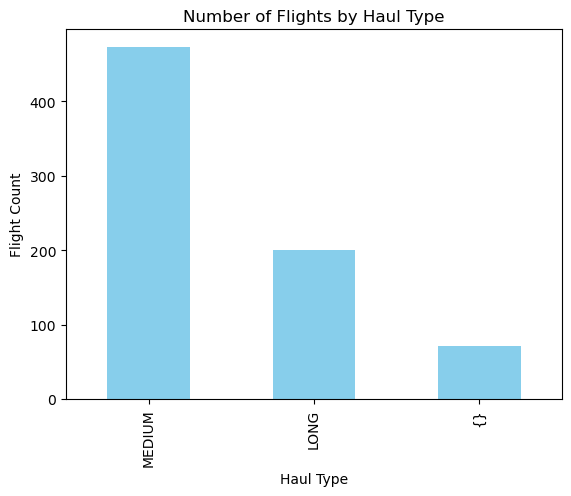

In [605]:
flight_df['haul'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of Flights by Haul Type')
plt.xlabel('Haul Type')
plt.ylabel('Flight Count')
plt.show()

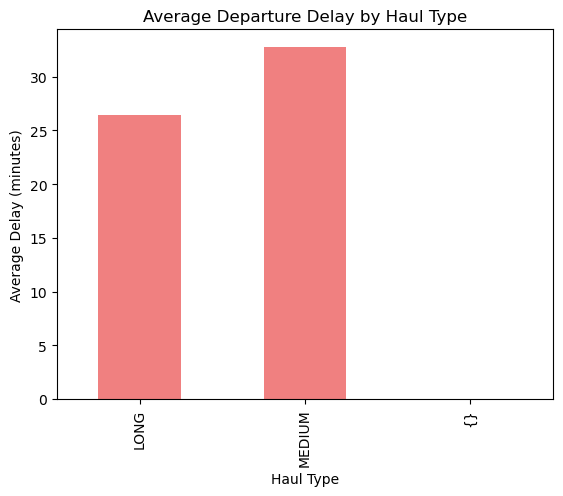

In [607]:
flight_df.groupby('haul')['delay_minutes'].mean().plot(kind='bar', color='lightcoral')
plt.title('Average Departure Delay by Haul Type')
plt.ylabel('Average Delay (minutes)')
plt.xlabel('Haul Type')
plt.show()

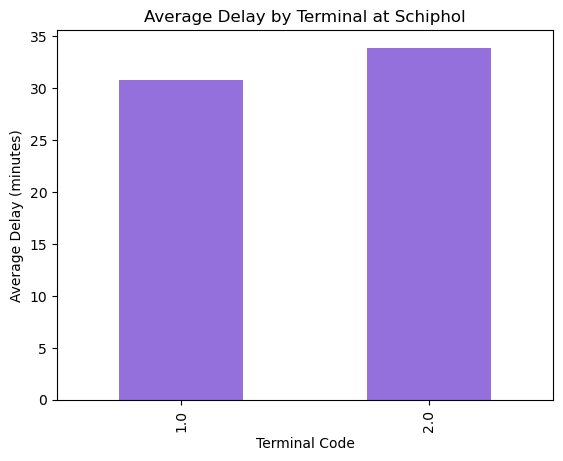

In [609]:
flight_df.groupby('terminal_code')['delay_minutes'].mean().plot(kind='bar', color='mediumpurple')
plt.title('Average Delay by Terminal at Schiphol')
plt.ylabel('Average Delay (minutes)')
plt.xlabel('Terminal Code')
plt.show()


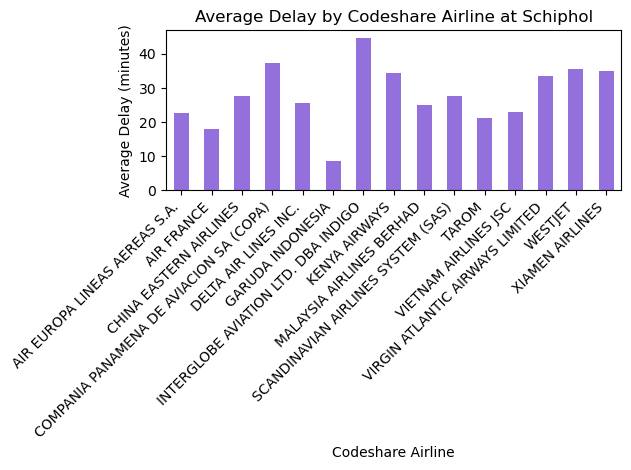

In [611]:
flight_df.groupby('codeshare_name')['delay_minutes'] \
    .mean() \
    .sort_index(ascending=True) \
    .plot(kind='bar', color='mediumpurple')

plt.title('Average Delay by Codeshare Airline at Schiphol')
plt.ylabel('Average Delay (minutes)')
plt.xlabel('Codeshare Airline')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [613]:
flight_df.columns 

Index(['date', 'airline_code', 'airline_name', 'flight_number',
       'flight_status_public', 'haul', 'codeshare_code', 'codeshare_name',
       'codeshare_date', 'codeshare_number', 'onward_code', 'onward_number',
       'onward_schedule', 'previous_code', 'previous_number',
       'previous_schedule', 'completion_percentage', 'time_difference',
       'arrival_airport_code', 'arrival_airport_name', 'configuration',
       'owner_airline', 'registration', 'wifi', 'code', 'gate_number',
       'boarding_contact_type', 'parking_position_type', 'pier_code',
       'terminal_code', 'delay_minutes', 'delay_binary'],
      dtype='object')

In [615]:
def chi_square_for_all(df, target_col, categorical_cols):
    results = []

    for col in categorical_cols:
        contingency = pd.crosstab(df[col], df[target_col])
        chi2, p, dof, expected = chi2_contingency(contingency)
        results.append({
            'feature': col,
            'chi2_statistic': chi2,
            'p_value': p,
            'degrees_of_freedom': dof
        })

    results_df = pd.DataFrame(results)
    results_df['significant'] = results_df['p_value'] < 0.05
    return results_df.sort_values('p_value')

categorical_cols = [
    'haul', 'codeshare_name', 'pier_code',
    'boarding_contact_type', 'parking_position_type', 'wifi',
     'arrival_airport_code', 'configuration', 'registration', 
    'terminal_code', 'code', 'gate_number'
]

chi_results = chi_square_for_all(flight_df, 'delay_binary', categorical_cols)
chi_results = pd.DataFrame(chi_results) 
chi_results.head(12) 

,feature,chi2_statistic,p_value,degrees_of_freedom,significant
0,haul,41.837976,8.222407e-10,2,True
10,code,44.260580,5.373772e-05,14,True
6,arrival_airport_code,171.933911,6.947191e-05,107,True
1,codeshare_name,37.917943,5.348890e-04,14,True
7,configuration,82.939147,6.869377e-04,46,True
9,terminal_code,8.196740,4.196573e-03,1,True
8,registration,216.293016,1.614289e-02,174,True
2,pier_code,10.604610,5.980810e-02,5,False
11,gate_number,124.263824,2.406557e-01,114,False
4,parking_position_type,0.985613,3.208170e-01,1,False


In [617]:
#feature selection 

significant_features = chi_results.loc[chi_results['significant'], 'feature'].tolist()


X = flight_df[significant_features].copy() 
y = flight_df['delay_binary'] 



In [619]:
X.columns

Index(['haul', 'code', 'arrival_airport_code', 'codeshare_name',
       'configuration', 'terminal_code', 'registration'],
      dtype='object')

In [621]:
X.head() 

,haul,code,arrival_airport_code,codeshare_name,configuration,terminal_code,registration
0,MEDIUM,E7W,FRA,VIETNAM AIRLINES JSC,C008M080,1.0,PHEXI
1,LONG,772,IAH,VIRGIN ATLANTIC AIRWAYS LIMITED,C035W024M229,2.0,PHBQN
2,LONG,77W,LIM,AIR FRANCE,C035W024M322,2.0,PHBVA
3,MEDIUM,E7W,SVG,MALAYSIA AIRLINES BERHAD,C012M076,1.0,PHEXU
4,MEDIUM,73H,WAW,KENYA AIRWAYS,C012M168,1.0,PHBGA


In [623]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42) 

In [625]:
categorical_features = X.columns.tolist()
encoder = OneHotEncoder(handle_unknown = 'ignore') 


In [627]:
preprocessor = ColumnTransformer(
    transformers=[('cat', encoder, categorical_features)], 
    remainder='drop'
)

In [629]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=3, random_state=42),
    "kNN": KNeighborsClassifier(n_neighbors=5)
}

In [631]:
for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = 42) 
    scores = cross_val_score(clf, X_train, y_train, cv = cv, scoring = 'f1') 
    
    
    print(f"\n--- {name} ---")
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
    print("F1-score:", round(f1_score(y_test, y_pred, average = 'binary'), 3))
    print("Mean F1 (CV):", scores.mean()) 


--- Random Forest ---
Accuracy: 0.597
F1-score: 0.725
Mean F1 (CV): 0.7741615917204034

--- Logistic Regression ---
Accuracy: 0.617
F1-score: 0.737
Mean F1 (CV): 0.7580089124809822

--- Decision Tree ---
Accuracy: 0.651
F1-score: 0.789
Mean F1 (CV): 0.8093087403079411

--- kNN ---
Accuracy: 0.664
F1-score: 0.771
Mean F1 (CV): 0.7581786192740536


In [5]:
print(y.value_counts(normalize=True))


NameError: name 'y' is not defined

In [635]:
print(y.value_counts(normalize=True))


delay_binary
1    0.653226
0    0.346774
Name: proportion, dtype: float64
